#### **Import necessary libraries**

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import joblib

#### **Load Pipeline**

In [47]:
model_path = '../resources/models/svm_classifier_pipeline.pkl'
final_model = joblib.load(model_path)

#### **Load Data**

In [48]:
file_path = "../resources/data/output/customer_churn_prepared.csv"   
df = pd.read_csv(file_path)

In [49]:
X = df.drop(columns=["churn"])

In [50]:
y = df["churn"]

In [51]:
# Extract components
preprocessor = final_model.named_steps["preprocessor"]
smote = final_model.named_steps["smote"]
classifier = final_model.named_steps["classifier"]

In [52]:
# Extract feature names
num_features = preprocessor.transformers_[0][2]
cat_encoder = preprocessor.transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
all_features = list(num_features) + list(cat_features)

In [53]:
# Fit on full dataset (X = features, y = target)
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['call_failure',
                                                   'subscription_length',
                                                   'complains',
                                                   'seconds_of_use',
                                                   'frequency_of_SMS',
                                                   'distinct_called_numbers',
                                                   'charge_amount',
                                                   'customer_value']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['status', 'tariff_plan',
                                                   'age_group'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

  0%|          | 0/100 [00:00<?, ?it/s]

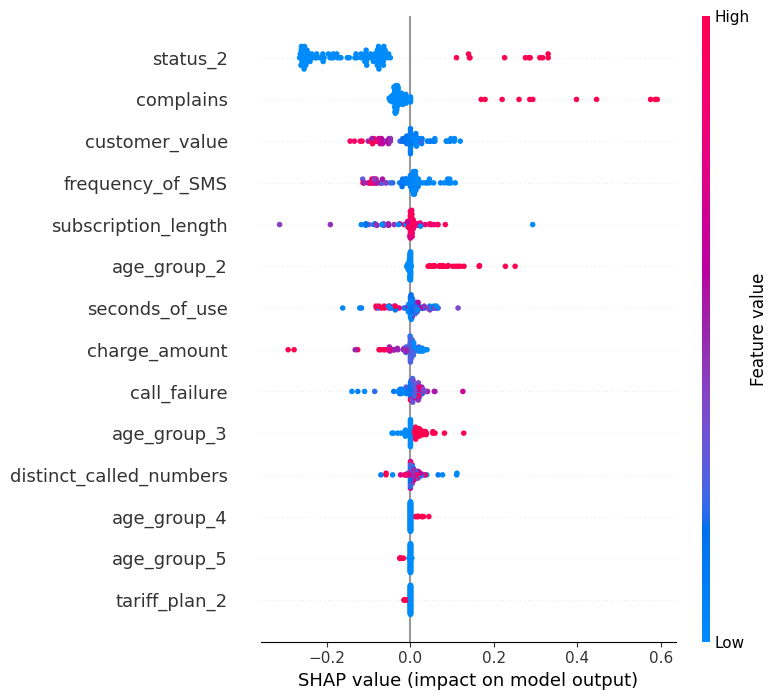

In [54]:
# Preprocess the features for SHAP
X_processed = final_model.named_steps["preprocessor"].transform(X)

# Create a background set for SHAP
background = shap.kmeans(X_processed, 10)

# Extract the SVM model for SHAP
svm_model = final_model.named_steps["classifier"]

# Create the KernelExplainer (model-agnostic)
explainer = shap.KernelExplainer(svm_model.predict_proba, background)

# If you only want to explain a subset of your data (say, first 100 rows):
X_sample = X_processed[:100]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Select the positive-class (index 1) SHAP values
shap_values_class1 = shap_values[:, :, 1]  # shape: (100, 14)

# Now call summary_plot with a 2D array
shap.summary_plot(
    shap_values_class1,
    X_sample,
    feature_names=all_features
)

**Strong Churn Drivers (Positive Impact):**

- Status_2: Being a non-active customer is the strongest predictor of churn
- Complains: Having complaints significantly increases churn probability
- Age_group_2: Younger customers show higher churn tendency

**Moderate Churn Risk (Mixed Impact):**

- Customer_value: Shows varying effects across different segments
- Frequency_of_SMS: Usage patterns have mixed influence on churn
- Subscription_length: Impact varies based on duration

**Retention Factors (Negative Impact):**

- Seconds_of_use: Higher usage generally indicates lower churn risk
- Charge_amount: Higher spending correlates with better retention
- Distinct_called_numbers: More diverse calling patterns suggest customer loyalty

**Minimal Impact Features:**

- Age_group_4 and Age_group_5: Show slight effects on churn
- Tariff_plan_2: Has minimal impact on churn decisions
- Call_failure: Shows relatively low influence on churn